# Naturally Interpretable Control Policies via Graph-based Genetic Programming

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
max_gens_dict = {
    "inverted_pendulum": 10,
    "inverted_double_pendulum": 1000,
    "reacher": 1000,
    "swimmer": 1000,
    "hopper": 1500,
    "walker2d": 1500,
    "halfcheetah": 500,
    "miniant": 2500
}

## Performance results

In [3]:
dataframes = [pd.read_csv(f"data/fitness/{d}") for d in os.listdir("data/fitness/") if d.startswith("ga")]
df = pd.concat(dataframes, ignore_index=True)
df = df[df["top_k_reward.top_0_reward"] > -1000]
df = pd.concat(
    [df[(df["environment"] == env) & (df["generation"] <= max_gens)] for env, max_gens in max_gens_dict.items()])
df.head()

,top_k_forward_reward.top_1_forward_reward,top_k_reward.top_1_reward,top_k_ctrl_reward.top_0_ctrl_reward,_step,_runtime,run_id,top_k_fit.top_2_fit,evaluation_time,top_k_healthy_reward.top_0_healthy_reward,fitness_std,...,solver,ea,fitness,environment,seed,evaluation,reward,forward,healthy,ctrl
75000,0.0,1000.0,0.0,0,15.853218,100,1000.0,10.212438,0.0,233.558701,...,cgp,mu+lambda-ga1,reward-unhealthy_termination,inverted_pendulum,100,0,608.600037,NaN,NaN,NaN
75001,0.0,1000.0,0.0,1,18.175278,100,1000.0,2.046917,0.0,366.012085,...,cgp,mu+lambda-ga1,reward-unhealthy_termination,inverted_pendulum,100,100,1000.000000,NaN,NaN,NaN
75002,0.0,1000.0,0.0,2,20.266994,100,1000.0,2.056581,0.0,452.317047,...,cgp,mu+lambda-ga1,reward-unhealthy_termination,inverted_pendulum,100,200,1000.000000,NaN,NaN,NaN
75003,0.0,1000.0,0.0,3,22.368208,100,1000.0,2.065638,0.0,476.949463,...,cgp,mu+lambda-ga1,reward-unhealthy_termination,inverted_pendulum,100,300,1000.000000,NaN,NaN,NaN
75004,0.0,1000.0,0.0,4,24.519554,100,1000.0,2.117298,0.0,487.493256,...,cgp,mu+lambda-ga1,reward-unhealthy_termination,inverted_pendulum,100,400,1000.000000,NaN,NaN,NaN


In [4]:
rl_df = pd.concat([pd.read_csv(f"data/rl/{d}") for d in os.listdir("data/rl/")])
rl_df.head()

,eval/avg_episode_length,eval/episode_reward_run,eval/epoch_eval_time,eval/episode_x_position,eval/episode_x_velocity,training/walltime,training/total_loss,eval/walltime,eval/episode_reward,training/policy_loss,...,eval/episode_reward_forward,eval/episode_reward_healthy,eval/episode_y_velocity,eval/episode_reward_contact,eval/episode_y_position,eval/episode_distance_from_origin,eval/episode_reward_survive,eval/episode_forward_reward,eval/episode_reward_dist,eval/episode_reward_fwd
0,1000.0,-42.114075,22.695604,-2671.642578,-42.114075,NaN,NaN,22.695604,-397.963135,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1000.0,438.107666,5.300664,10394.796875,438.107666,35.266025,3.703657,27.996268,263.874603,0.029212,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1000.0,899.020142,5.261177,21811.003906,899.020142,52.338530,5.773283,33.257445,713.936462,-0.006803,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1000.0,1172.869995,5.285977,28698.984375,1172.869995,69.451029,7.792946,38.543422,989.727295,-0.004934,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1000.0,1492.364502,5.262570,37059.125000,1492.364502,86.561281,8.875581,43.805993,1313.385254,-0.004631,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
rl_final = rl_df[rl_df.groupby(["environment", "rl_algorithm"])["_step"].transform(max) == rl_df["_step"]][
    ["environment", "rl_algorithm", "eval/episode_reward", "seed"]]
graph_gp_final = df[df.groupby(["environment", "solver"])["generation"].transform(max) == df["generation"]][
    ["environment", "solver", "top_k_reward.top_0_reward", "seed"]]
rl_final.columns.values[1] = "solver"
rl_final.columns.values[2] = graph_gp_final.columns.values[2] = "reward"
graph_gp_final["reward"] = graph_gp_final["reward"]
rl_final["method"] = "RL"
graph_gp_final["method"] = "GP"
df_final = pd.concat([rl_final, graph_gp_final])
df_final.head()

,environment,solver,reward,seed,method
19,halfcheetah,ppo,6065.511719,0,RL
19,halfcheetah,ppo,7507.739258,1,RL
19,halfcheetah,ppo,7758.751953,2,RL
19,halfcheetah,ppo,6600.005859,3,RL
19,halfcheetah,ppo,5095.306641,4,RL


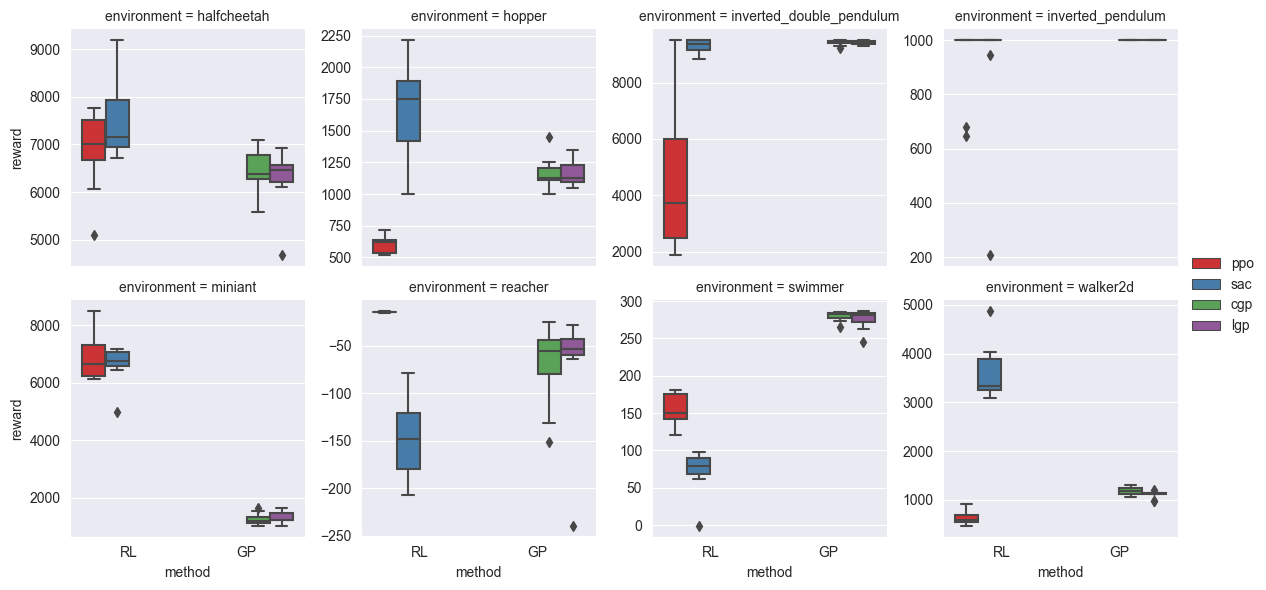

In [6]:
g = sns.FacetGrid(df_final, col="environment", col_wrap=4, sharey=False)
g.map_dataframe(sns.boxplot, x="method", y="reward", hue="solver", palette="Set1")
g.add_legend()
g.set_ylabels("reward")
plt.show()

In [7]:
from scipy.stats import mannwhitneyu

df_tuples = []
solvers = ["cgp", "lgp", "ppo", "sac"]
for env in max_gens_dict.keys():
    for s1 in range(len(solvers)):
        for s2 in range(s1 + 1, len(solvers)):
            tmp = df_final[df_final["environment"] == env]
            res = mannwhitneyu(tmp[tmp["solver"] == solvers[s1]]["reward"].tolist(),
                               tmp[tmp["solver"] == solvers[s2]]["reward"].tolist())
            df_tuples.append(
                (env, f"{solvers[s1]}-{solvers[s2]}", res.pvalue)
            )
pvalues_df = pd.DataFrame(df_tuples, columns=["environment", "comparison", "pvalue"])
pvalues_df.head()

,environment,comparison,pvalue
0,inverted_pendulum,cgp-lgp,1.000000
1,inverted_pendulum,cgp-ppo,0.168078
2,inverted_pendulum,cgp-sac,0.077872
3,inverted_pendulum,lgp-ppo,0.168078
4,inverted_pendulum,lgp-sac,0.077872


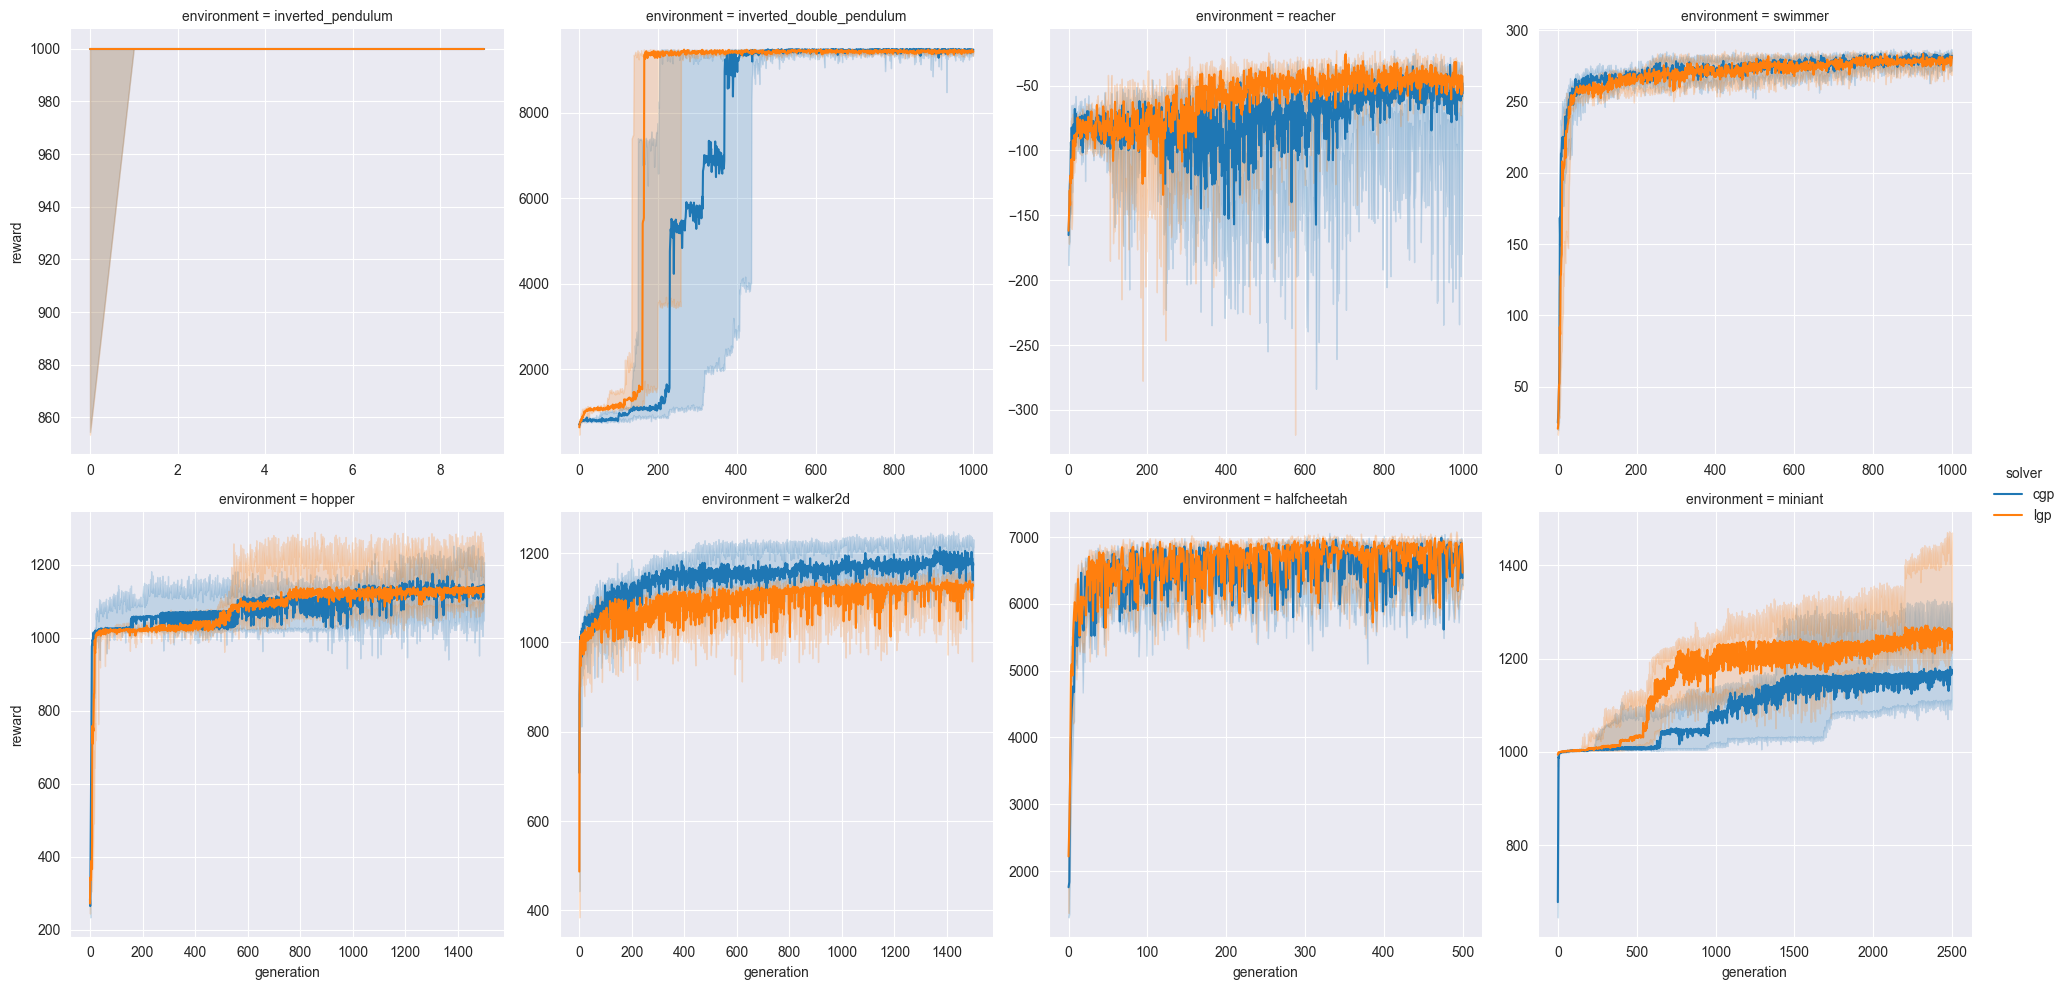

In [8]:
g = sns.relplot(
    data=df,
    x="generation",
    y="reward",
    hue="solver",
    col="environment",
    col_wrap=4,
    kind="line",
    estimator="median",
    errorbar=("pi", 50),
    facet_kws=dict(sharey=False, sharex=False)
)
plt.show()

## Interpretability of resulting policies

In [9]:
graph_dfs = [pd.read_csv(f"data/graph_size/{d}") for d in os.listdir("data/graph_size/") if d.startswith("ga")]
graph_sizes = pd.concat(graph_dfs, ignore_index=True)
graph_sizes = pd.concat(
    [graph_sizes[(graph_sizes["environment"] == env) & (graph_sizes["generation"] <= max_gens)] for env, max_gens in
     max_gens_dict.items()])
graph_sizes.head()

,seed,generation,evaluation,graph_size,max_size,solver,ea,fitness,environment,relative_size
750,100,7,7777777777777777777777777777777777777777777777...,15,56,cgp,mu+lambda-ga1,reward-unhealthy_termination,inverted_pendulum,0.267857
751,100,4,4444444444444444444444444444444444444444444444...,15,56,cgp,mu+lambda-ga1,reward-unhealthy_termination,inverted_pendulum,0.267857
752,100,6,6666666666666666666666666666666666666666666666...,15,56,cgp,mu+lambda-ga1,reward-unhealthy_termination,inverted_pendulum,0.267857
753,100,0,0000000000000000000000000000000000000000000000...,7,56,cgp,mu+lambda-ga1,reward-unhealthy_termination,inverted_pendulum,0.125000
754,100,8,8888888888888888888888888888888888888888888888...,15,56,cgp,mu+lambda-ga1,reward-unhealthy_termination,inverted_pendulum,0.267857


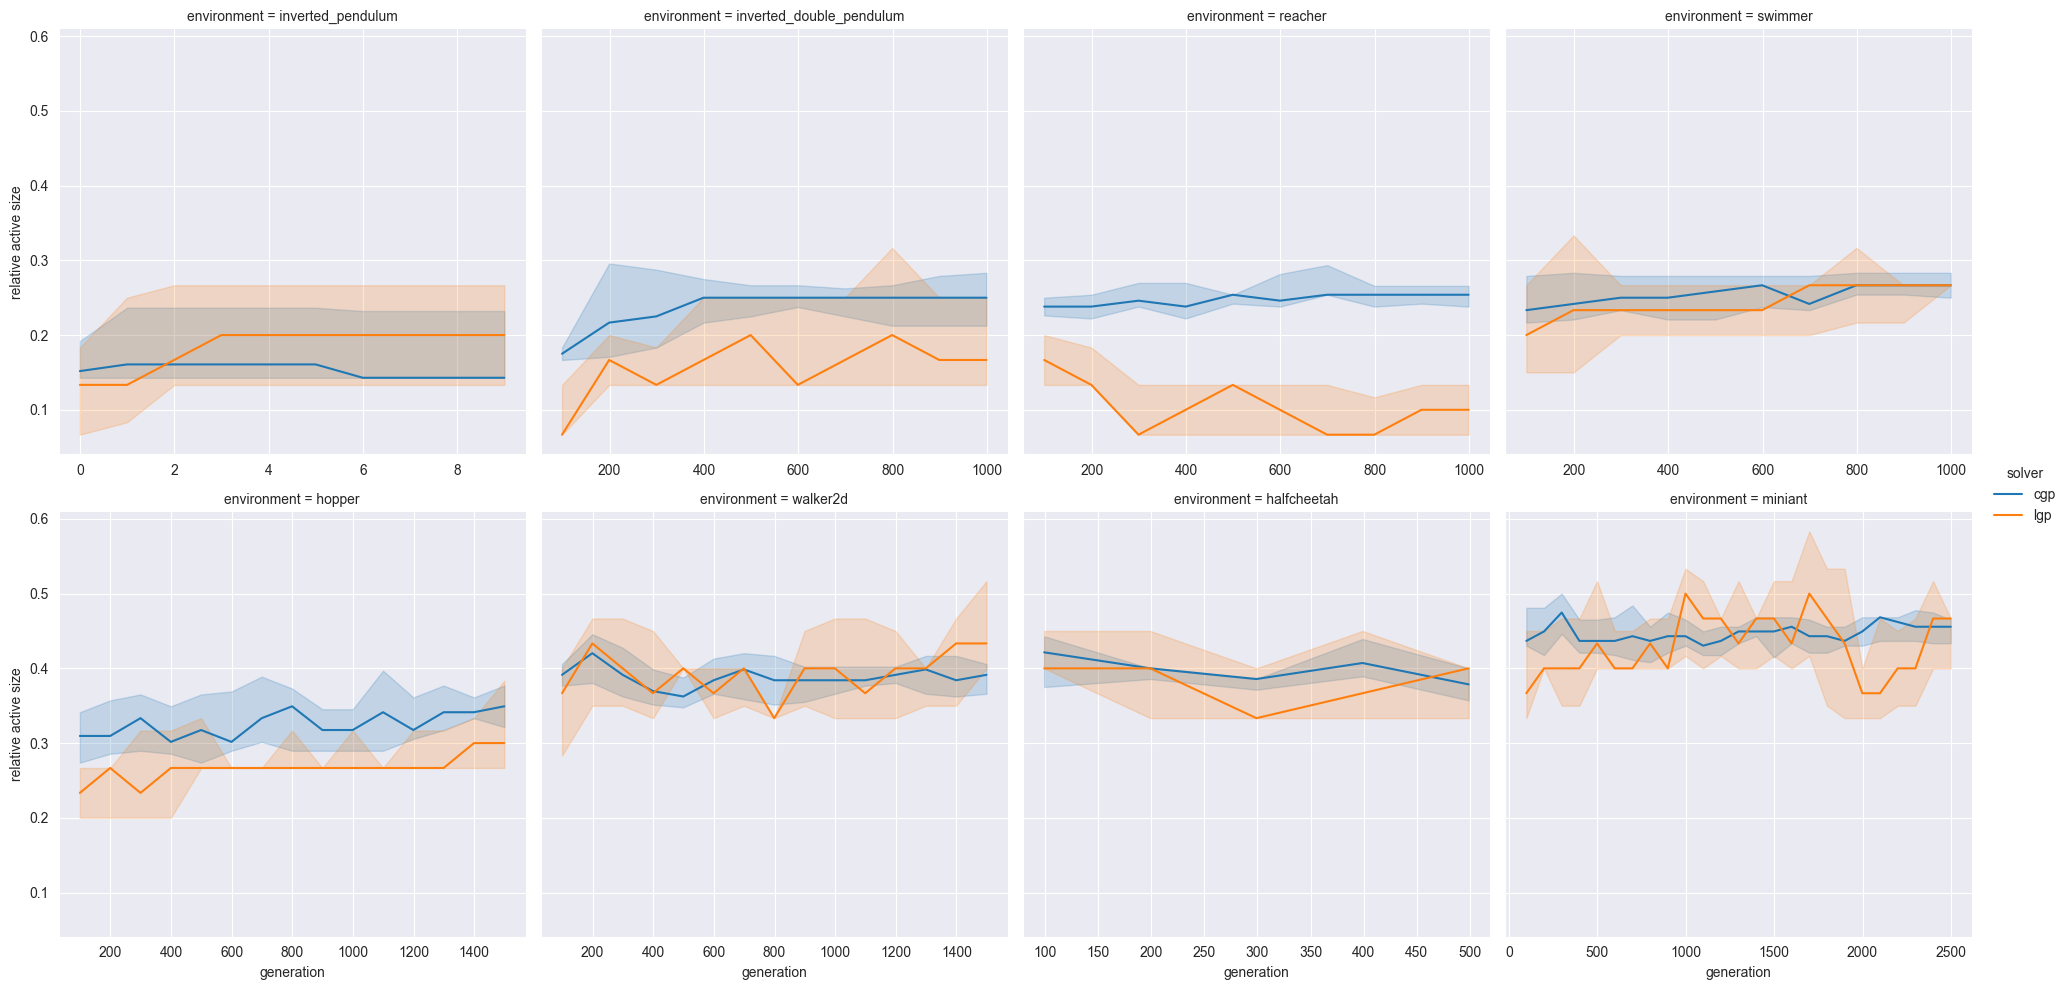

In [10]:
g = sns.relplot(
    data=graph_sizes,
    col="environment",
    col_wrap=4,
    kind="line",
    x="generation",
    y="relative_size",
    hue="solver",
    estimator="median",
    errorbar=("pi", 50),
    facet_kws=dict(sharex=False)
)
g.set_xlabels("generation")
g.set_ylabels("relative active size")
plt.show()

In [11]:
interpretability_dfs = [pd.read_csv(f"data/interpretability/{d}") for d in os.listdir("data/interpretability/")]
interpretability = pd.concat(interpretability_dfs, ignore_index=True)
interpretability = pd.concat(
    [interpretability[(interpretability["environment"] == env) & (interpretability["generation"] <= max_gens)] for
     env, max_gens in max_gens_dict.items()])
interpretability.head()

,generation,n_edges,phi,n_single_arity,n_double_arity,n_inputs,solver,environment,seed
35751,599,5,68.5,1,2,2,cgp,inverted_double_pendulum,100
35753,899,5,68.5,1,2,2,cgp,inverted_double_pendulum,100
35756,999,5,68.5,1,2,2,cgp,inverted_double_pendulum,100
35757,199,5,68.5,1,2,2,cgp,inverted_double_pendulum,100
35760,799,5,68.5,1,2,2,cgp,inverted_double_pendulum,100


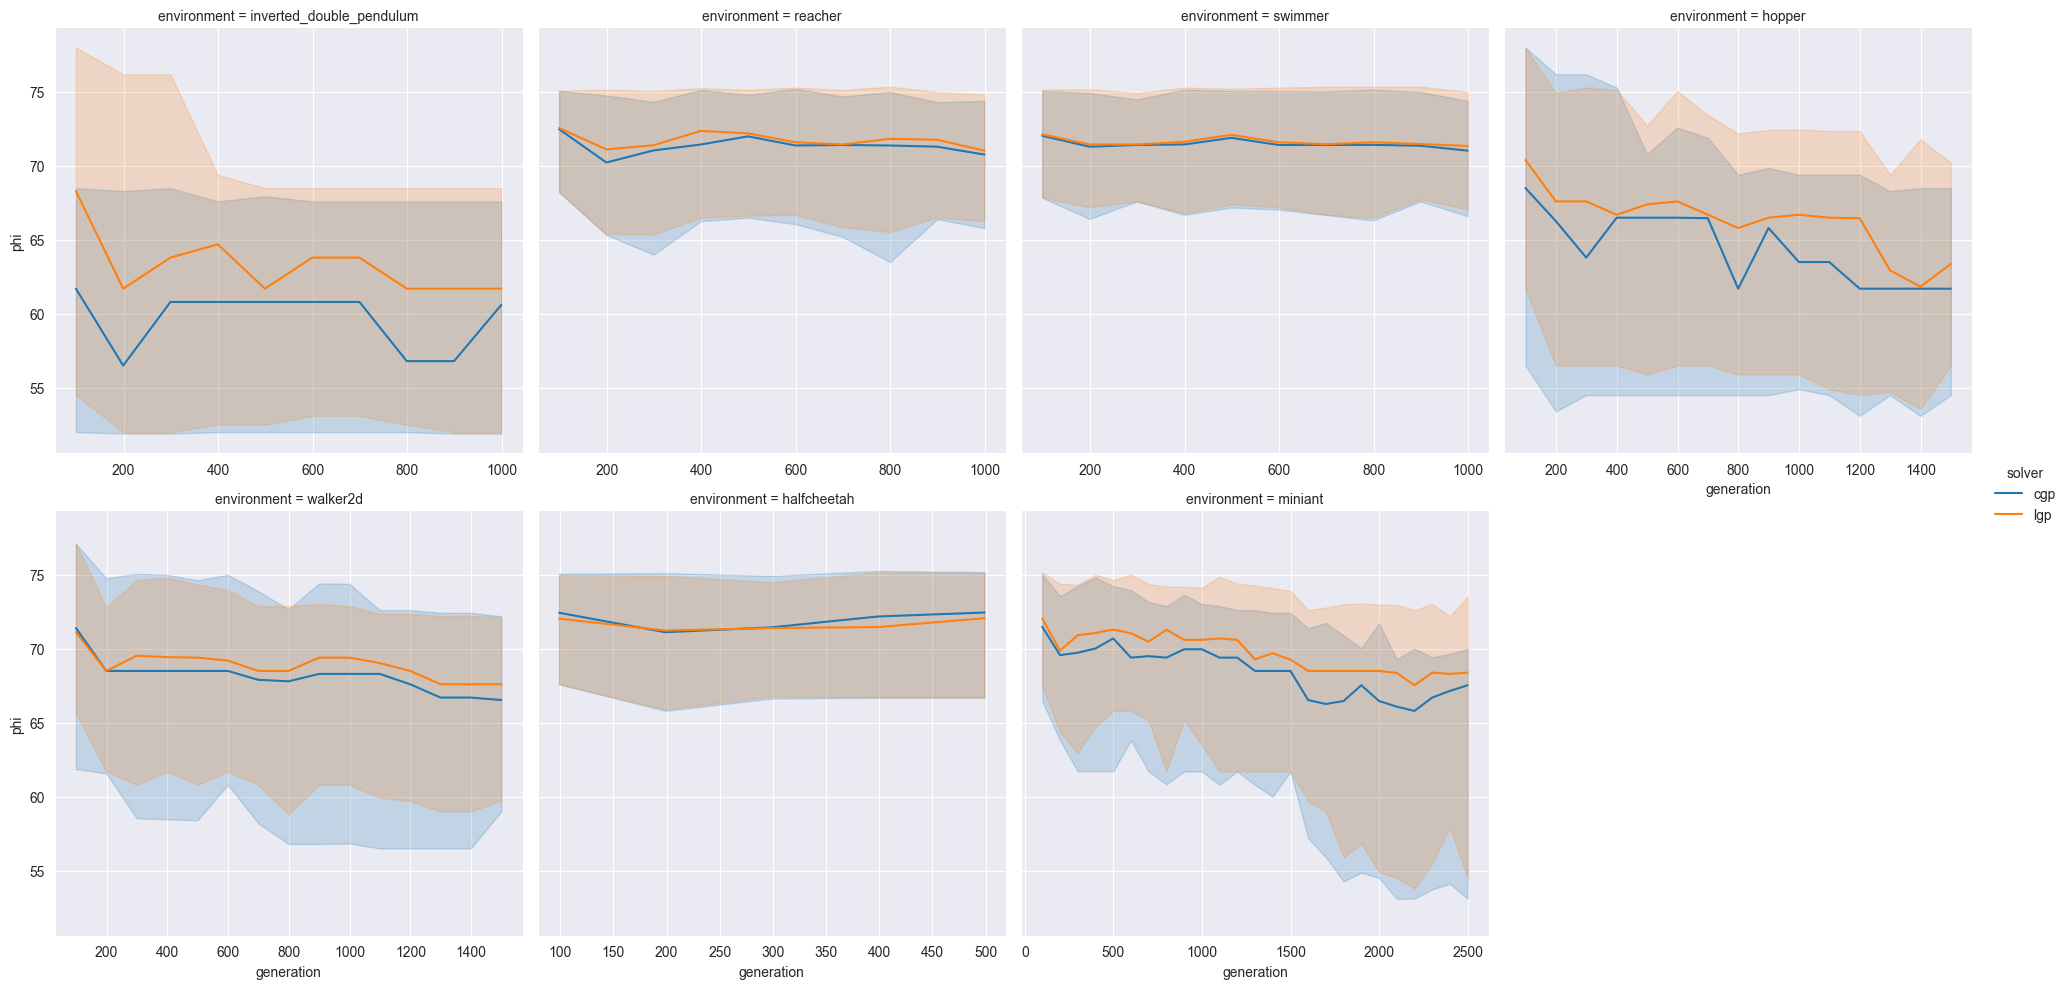

In [12]:
g = sns.relplot(
    data=interpretability,
    x="generation",
    y="phi",
    hue="solver",
    col="environment",
    col_wrap=4,
    kind="line",
    estimator="median",
    errorbar=("pi", 50),
    facet_kws=dict(sharex=False)
)
plt.show()

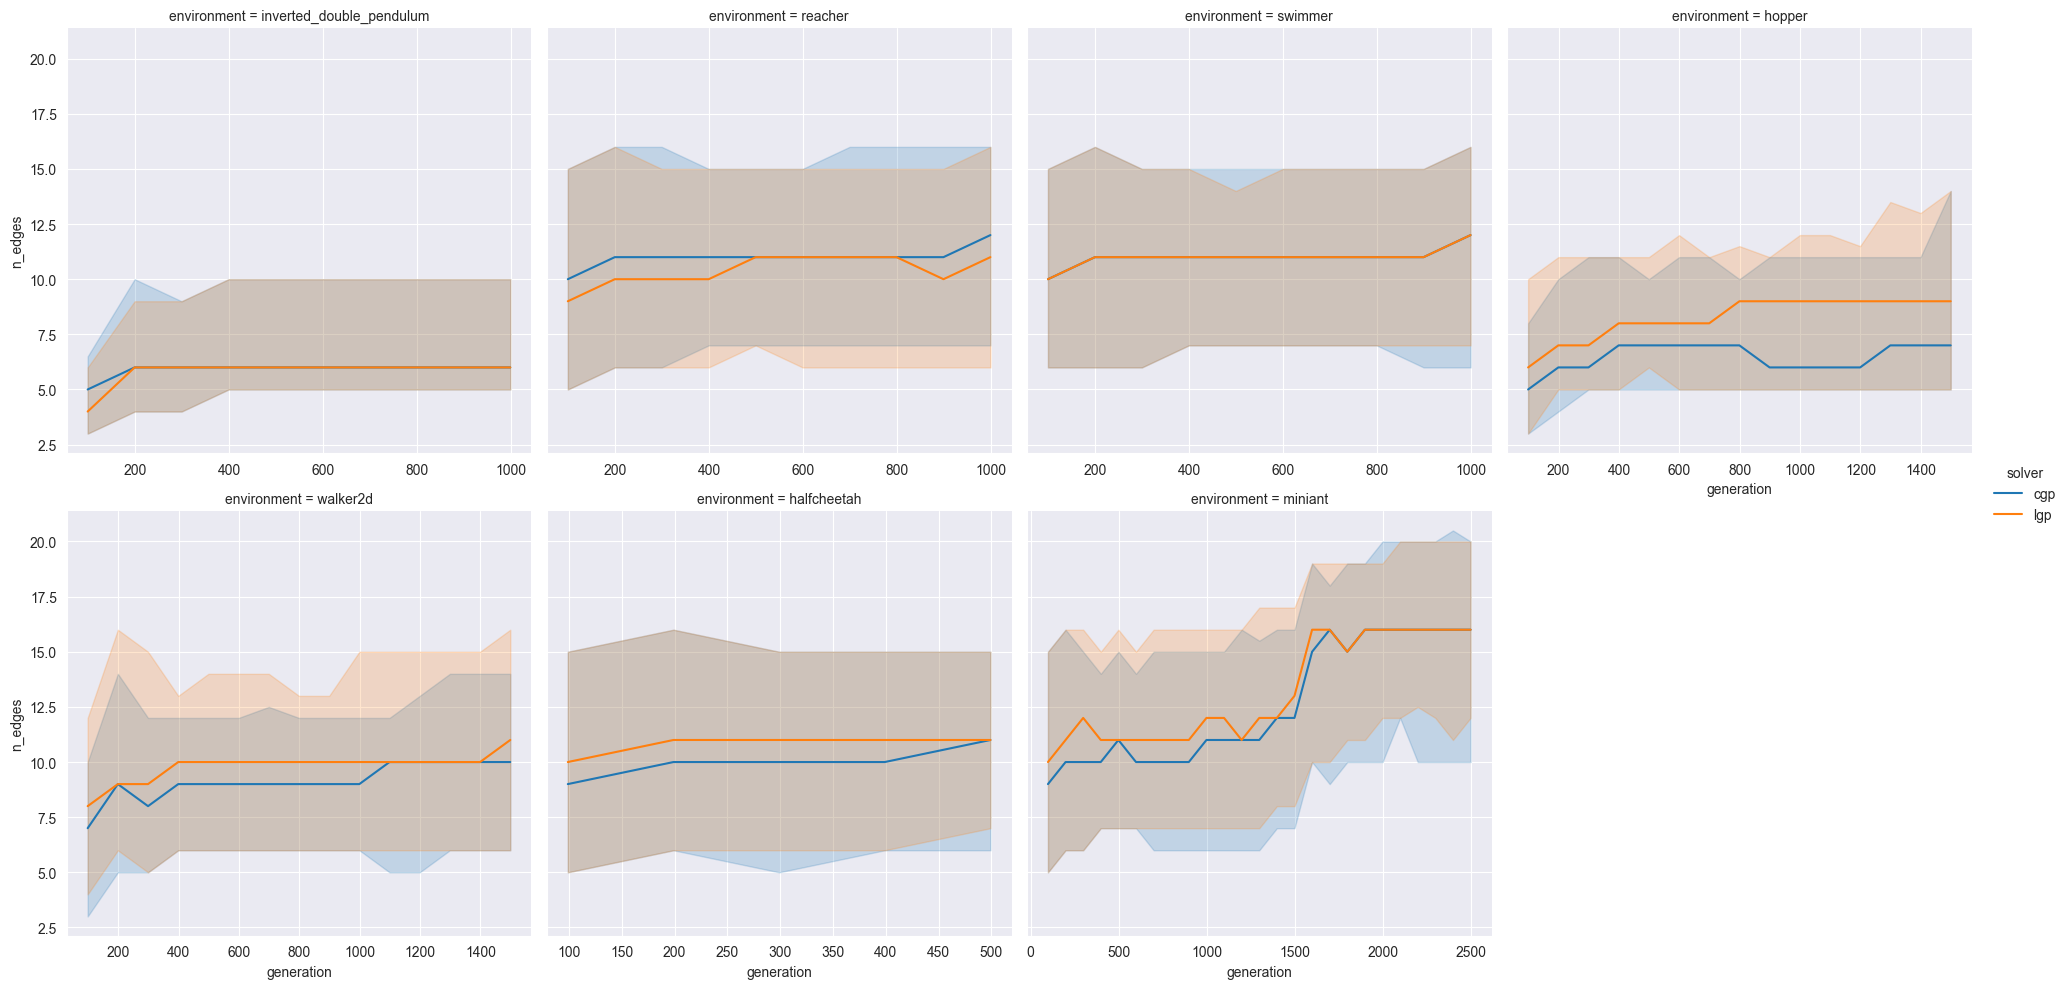

In [13]:
g = sns.relplot(
    data=interpretability,
    x="generation",
    y="n_edges",
    hue="solver",
    col="environment",
    col_wrap=4,
    kind="line",
    estimator="median",
    errorbar=("pi", 50),
    facet_kws=dict(sharex=False)
)
plt.show()

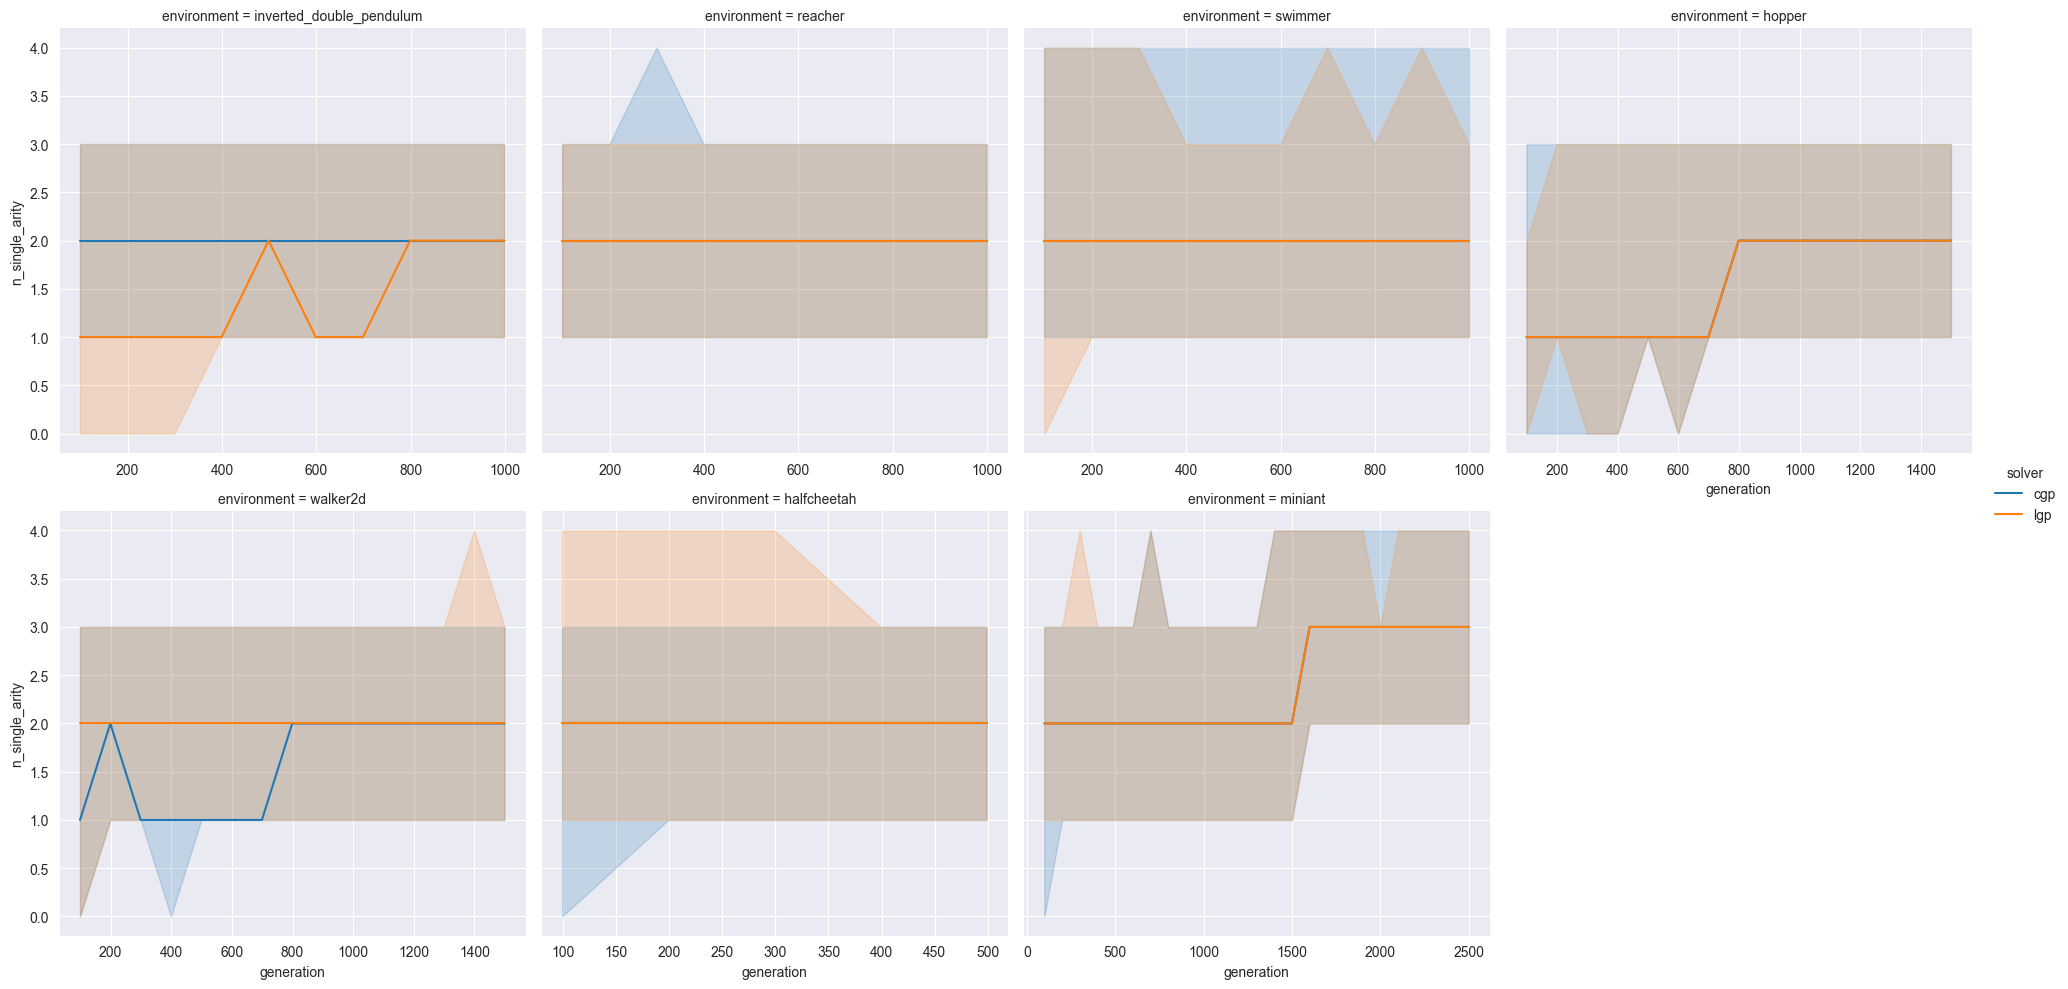

In [14]:
variables = ["n_single_arity", "n_double_arity", "n_inputs"]
var = variables[0]
plt.show()
g = sns.relplot(
    data=interpretability,
    col="environment",
    col_wrap=4,
    kind="line",
    x="generation",
    y=var,
    hue="solver",
    estimator="median",
    errorbar=("pi", 50),
    facet_kws=dict(sharex=False)
)
plt.show()

In [15]:
graph_sizes_final = graph_sizes[
    graph_sizes.groupby(["environment", "solver"])["generation"].transform(max) == graph_sizes["generation"]][
    ["environment", "solver", "relative_size", "seed"]]
graph_gp_final_with_size = pd.merge(graph_gp_final, graph_sizes_final, how="inner",
                                    on=["solver", "environment", "seed"])

mo_dfs = [pd.read_csv(f"data/fitness/{d}") for d in os.listdir("data/fitness/") if d.startswith("nsga2")]
mo_df = pd.concat(mo_dfs, ignore_index=True)
mo_df["complexity"] = 1 - mo_df["simplicity"]
mo_df.head()

,iteration,front_size,reward,simplicity,seed,environment,solver,complexity
0,0,1,662.60950,0.833333,0,inverted_double_pendulum,cgp,0.166667
1,1,1,662.60950,0.833333,0,inverted_double_pendulum,cgp,0.166667
2,2,1,767.14435,0.833333,0,inverted_double_pendulum,cgp,0.166667
3,3,1,671.69740,0.833333,0,inverted_double_pendulum,cgp,0.166667
4,4,1,700.36383,0.833333,0,inverted_double_pendulum,cgp,0.166667


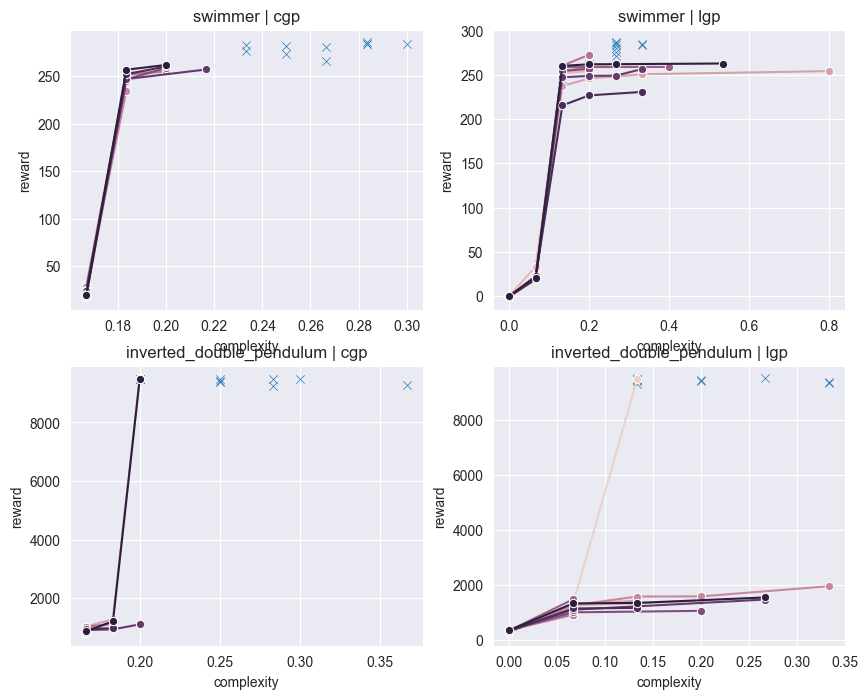

In [16]:
envs = ["swimmer", "inverted_double_pendulum"]
mo_df_final = mo_df[mo_df.groupby(["seed", "environment", "solver"])["iteration"].transform(max) == mo_df["iteration"]]
solvers = ["cgp", "lgp"]

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

for idx in range(2):
    for idy in range(2):
        curr_env = envs[idx]
        curr_solver = solvers[idy]
        extra_data = graph_gp_final_with_size[
            (graph_gp_final_with_size["solver"] == curr_solver) &
            (graph_gp_final_with_size["environment"] == curr_env)
            ]
        sns.lineplot(
            mo_df_final[
                (mo_df_final["solver"] == curr_solver) &
                (mo_df_final["environment"] == curr_env)
                ],
            x="complexity",
            y="reward",
            hue="seed",
            marker="o",
            legend=False,
            ax=axs[idx][idy]
        )
        sns.scatterplot(
            x=extra_data["relative_size"],
            y=extra_data["reward"],
            marker="x",
            legend=False,
            ax=axs[idx][idy]
        )
        axs[idx][idy].set_title(f"{curr_env} | {curr_solver}")

plt.show()

## Data export

In [17]:
data_export = False

from statistics import median
from typing import List, Union

from pandas import DataFrame


def line_plot(df: DataFrame, x: str, y: Union[List[str], str], groups: Union[List[str], str] = None,
              file_prefix: str = "", cols_joiner: str = "_", filename_joiner: str = "_"):
    """ Exports data to individual files for line plots with median as main line and shaded area between quartiles.

        Parameters:
        df : dataframe
        x : x-axis column
        y : y-axis column(s)
        groups : grouping variable column(s)
        file_prefix : prefix to prepend to every file generated
        cols_joiner : joiner for columns
        filename_joiner : joiner for file name

       """

    if type(y) == str:
        y = [y]
    if type(groups) == str:
        groups = [groups]

    def q1(a):
        return a.quantile(0.25)

    def q3(b):
        return b.quantile(0.75)

    vals = dict([(key, [q1, q3, median]) for key in y])

    summary = df.groupby(groups + [x]).agg(vals)
    summary.columns = [cols_joiner.join(col) for col in summary.columns.to_flat_index()]
    summary.reset_index(inplace=True)

    key_df = df.drop_duplicates(subset=groups)

    for i in range(len(key_df)):
        tmp = summary
        current_filename = file_prefix
        for key in groups:
            tmp = tmp[tmp[key] == key_df[key].iloc[i]]
            current_filename += f"{filename_joiner if len(current_filename) > 0 and not current_filename.endswith('/') else ''}{key_df[key].iloc[i]}"
        tmp.to_csv(f"{current_filename}.txt", sep="\t", index=False)


def box_plot(df: DataFrame, x: str, y: str, groups: Union[List[str], str] = None, file_prefix: str = "",
             filename_joiner: str = "_"):
    """ Exports data to individual files for box plots.

        Parameters:
        df : dataframe
        x : x-axis column
        y : y-axis column(s)
        groups : grouping variable column(s)
        file_prefix : prefix to prepend to every file generated
        cols_joiner : joiner for columns
        filename_joiner : joiner for file name

       """

    if type(groups) == str:
        groups = [groups]
    if groups is None or len(groups) == 0:
        _box_plot(df, x, y, file_prefix)

    else:
        key_df = df.drop_duplicates(subset=groups)

        for i in range(len(key_df)):
            tmp = df
            current_filename = file_prefix
            for key in groups:
                tmp = tmp[tmp[key] == key_df[key].iloc[i]]
                current_filename += f"{filename_joiner if len(current_filename) > 0 else ''}{key_df[key].iloc[i]}"
            _box_plot(tmp, x, y, current_filename)


def _box_plot(df: DataFrame, x: str, y: str, file_name: str):
    plt.figure(visible=False)
    data = []
    for xi in df[x].unique():
        data.append([k for k in df[df[x] == xi][y] if str(k) != "nan"])

    bp = plt.boxplot(data, showmeans=False)

    minimums = [round(item.get_ydata()[0], 1) for item in bp['caps']][::2]
    q1 = [round(min(item.get_ydata()), 1) for item in bp['boxes']]
    medians = [item.get_ydata()[0] for item in bp['medians']]
    q3 = [round(max(item.get_ydata()), 1) for item in bp['boxes']]
    maximums = [round(item.get_ydata()[0], 1) for item in bp['caps']][1::2]

    rows = [df[x].unique().tolist(), minimums, q1, medians, q3, maximums]

    with open(f"{file_name}.txt", "w") as bp_file:
        for row in rows:
            bp_file.write("\t".join(map(str, row)) + "\n")

In [18]:
if data_export:
    line_plot(df, x="generation", y="reward", groups=["solver", "environment"], file_prefix="../pgfplots/evolution")
    line_plot(graph_sizes, x="generation", y="relative_size", groups=["solver", "environment"],
              file_prefix="../pgfplots/sizes")
    box_plot(df_final, x="solver", y="reward", groups=["environment"], file_prefix="../pgfplots/final")

In [19]:
if data_export:
    def _process_env(env: str) -> str:
        return env.replace("mini", "").replace("fc", "f C").replace("erted_", ".\ ").replace("le_pendulum",
                                                                                             ".\ Pend.").capitalize()


    environments = max_gens_dict.keys()
    comparisons = ["cgp-ppo", "cgp-sac"]
    table_string = ""
    for env in environments:
        pval = pvalues_df[pvalues_df["environment"] == env]
        cgp = " & ".join([f'{pval[pval["comparison"] == cmp]["pvalue"].tolist()[0]:.3f}' for cmp in comparisons])
        lgp = " & ".join(
            [f'{pval[pval["comparison"] == cmp.replace("cg", "lg")]["pvalue"].tolist()[0]:.3f}' for cmp in comparisons])
        table_string += f"\\subcaptionbox{{{_process_env(env)}}}{{\n"
        table_string += f"    \\begin{{tabular}}{{\n"
        table_string += f"        l\n"
        table_string += f"        S[table-format=1.3]\n"
        table_string += f"        S[table-format=1.3]\n"
        table_string += f"    }}\n"
        table_string += f"        \\toprule\n"
        table_string += f"        & {{\\gls{{ppo}}}} & {{\\gls{{sac}}}} \\\\\n"
        table_string += f"        \\midrule\n"
        table_string += f"        {{\gls{{cgp}}}} & {cgp} \\\\\n"
        table_string += f"        {{\gls{{lgp}}}} & {lgp} \\\\\n"
        table_string += f"        \\bottomrule\n"
        table_string += f"    \\end{{tabular}}\n"
        table_string += f"}}\n"

    with open("../pgfplots/pvalues.txt", "w+") as f:
        f.write(table_string)

In [20]:
if data_export:
    envs = ["swimmer", "inverted_double_pendulum"]
    mo_df_final = mo_df[
        mo_df.groupby(["seed", "environment", "solver"])["iteration"].transform(max) == mo_df["iteration"]]
    solvers = ["cgp", "lgp"]

    for curr_env in envs:
        for curr_solver in solvers:
            extra_data = graph_gp_final_with_size[
                (graph_gp_final_with_size["solver"] == curr_solver) &
                (graph_gp_final_with_size["environment"] == curr_env)
                ][["reward", "relative_size"]]
            extra_data.to_csv(f"../pgfplots/complexity_{curr_solver}_{curr_env}.txt", index=False, sep="\t")
            tmp_mo_df_final = mo_df_final[
                (mo_df_final["solver"] == curr_solver) &
                (mo_df_final["environment"] == curr_env)
                ]
            for seed in tmp_mo_df_final["seed"].unique():
                curr_df = tmp_mo_df_final[tmp_mo_df_final["seed"] == seed][["reward", "complexity"]]
                curr_df.to_csv(f"../pgfplots/nsga_{curr_solver}_{curr_env}_{seed}.txt", index=False, sep="\t")